# Q learning vs Double Q-learning

In [19]:
# imports 
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"
import gym

from windy_gridworld import WindyGridworldEnv

In [162]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon=None):
        self.Q = Q
        self.epsilon = epsilon
        self.state_counts = np.ones(self.Q.shape[0])
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if self.epsilon == None:
            epsilon = 1/self.state_counts[obs]
        else:
            epsilon = self.epsilon
            
        if np.random.rand() < epsilon:
            action = np.random.randint(0, len(self.Q[obs]))
        else:
            max_q = np.where(np.max(self.Q[obs]) == self.Q[obs])[0]
            action = np.random.choice(max_q)
        return action
    
    def update_epsilon(self, obs):
        self.state_counts[obs] += 1
    
class EpsilonGreedyPolicyDoubleQ(object):
    """
    A simple epsilon greedy policy, taking average over the two Q functions.
    Q [state, 2, action]
    """
    def __init__(self, Q, epsilon=None):
        self.Q = Q
        self.epsilon = epsilon
        self.state_counts = np.ones(self.Q.shape[0])
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        if self.epsilon == None:
            epsilon = 1/self.state_counts[obs]
        else:
            epsilon = self.epsilon
            
        if np.random.rand() < epsilon:
            action = np.random.randint(0, len(self.Q[obs, 0]))
        else:
            qtable_sum = self.Q[obs][0] + self.Q[obs][1]
            # Randomly break ties
            max_q = np.where(np.max(qtable_sum) == qtable_sum)[0]
            action = np.random.choice(max_q)
        return action
    
    def update_epsilon(self, obs):
        self.state_counts[obs] += 1

In [163]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

In [164]:
def q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        # convert tuple s to corresponding int if necessary
        if isinstance(s, tuple):
            int_s = 0
            temp = 1
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])
            s = sum([y*x for x, y in zip(s, space_coeff)])
        policy.update_epsilon(s)
            
        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            policy.update_epsilon(s_new)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            if done != True:
                Q[s, a] += alpha * (r + discount_factor * np.max(Q[s_new]) - Q[s, a])
            else:
                Q[s, a] += alpha * (r - Q[s, a])
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)



In [165]:
def double_q_learning(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        policy: A behavior policy which allows us to sample actions with its sample_action method.
        Q: Q value function [states, 2, actions]
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        s = env.reset()
        if isinstance(s, tuple):
            space_coeff = [1]
            for x in env.observation_space.spaces[:-1]:
                space_coeff.append(x.n*space_coeff[-1])
            s = sum([y*x for x, y in zip(s, space_coeff)])
        policy.update_epsilon(s)

        while True:
            a = policy.sample_action(s)
            s_new, r, done, info = env.step(a)
            policy.update_epsilon(s_new)
            if isinstance(s_new, tuple):
                s_new = sum([y*x for x, y in zip(s_new, space_coeff)])
            # flip coin, choose Q function
            c = int(np.random.rand() < 0.5)
            max_a = np.argmax(Q[s_new, c])
            if done != True:
                Q[s, c, a] += alpha * (r + discount_factor * Q[s_new, (c-1)**2 , max_a] - Q[s, c, a])
            else:
                Q[s, c, a] += alpha * (r  - Q[s, c, a])
            
            s = s_new
            
            i += 1
            R += r
            if done == True:
                break
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)


In [166]:
def running_mean(vals, n=1):
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n

# Environments

In [167]:
# initialize envs and Q values
wind_env = WindyGridworldEnv()
Q_single_wind = np.zeros((wind_env.nS, wind_env.nA))
Q_double_wind = np.zeros((wind_env.nS, 2, wind_env.nA))

roul_env = gym.make('Roulette-v0')
Q_single_roul = np.zeros([roul_env.observation_space.n, roul_env.action_space.n])
Q_double_roul = np.zeros(([roul_env.observation_space.n, 2, roul_env.action_space.n]))

frozen_env = gym.make('FrozenLake-v0')
Q_single_frozen = np.zeros([frozen_env.observation_space.n, frozen_env.action_space.n])
Q_double_frozen = np.zeros(([frozen_env.observation_space.n, 2, frozen_env.action_space.n]))


## 1. Test a single run

In [ ]:
env = frozen_env
Q_single = np.copy(Q_single_frozen)
Q_double = np.copy(Q_double_frozen)
epsilon = None
num_episodes = 100000

# single Q learning
policy_single = EpsilonGreedyPolicy(Q_single, epsilon=epsilon)
Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, policy_single, Q_single, num_episodes, alpha=0.8)
# double Q learning
policy_double = EpsilonGreedyPolicyDoubleQ(Q_double, epsilon=epsilon)
Q_double_q_learning, (episode_lengths_double_q_learning, episode_returns_double_q_learning) = double_q_learning(env, policy_double, Q_double, num_episodes, alpha=0.8)

n = 100
plt.plot(running_mean(episode_returns_q_learning, n))
plt.plot(running_mean(episode_returns_double_q_learning, n))
plt.title('Episode returns')
plt.legend(['Q-Learning', 'Double Q learning'])
plt.show()




  0%|                                                | 0/100000 [00:00<?, ?it/s]


  1%|▎                                    | 966/100000 [00:01<01:42, 965.62it/s]


  2%|▌                                   | 1500/100000 [00:02<02:06, 776.55it/s]


  2%|▋                                   | 1970/100000 [00:03<02:31, 649.09it/s]


  2%|▊                                   | 2409/100000 [00:04<02:51, 567.47it/s]


  3%|█                                   | 2845/100000 [00:05<03:06, 520.29it/s]


  3%|█▏                                  | 3301/100000 [00:06<03:13, 499.11it/s]


  4%|█▎                                  | 3774/100000 [00:07<03:15, 490.95it/s]


  4%|█▌                                  | 4216/100000 [00:08<03:23, 470.81it/s]


  5%|█▋                                  | 4654/100000 [00:09<03:30, 453.53it/s]


  5%|█▊                                  | 5094/100000 [00:10<03:31, 449.13it/s]


  6%|██                                  | 5576/100000 [00:11<03:26, 458.26it/s]


 

 38%|█████████████▏                     | 37759/100000 [01:33<02:19, 447.01it/s]


 38%|█████████████▎                     | 38207/100000 [01:34<02:18, 447.09it/s]


 39%|█████████████▌                     | 38655/100000 [01:35<02:29, 409.01it/s]


 39%|█████████████▋                     | 39076/100000 [01:36<02:27, 412.14it/s]


 39%|█████████████▊                     | 39493/100000 [01:37<02:32, 396.32it/s]


 40%|█████████████▉                     | 39894/100000 [01:38<02:37, 382.80it/s]


 40%|██████████████                     | 40305/100000 [01:39<02:32, 390.17it/s]


 41%|██████████████▏                    | 40699/100000 [01:41<02:36, 377.75it/s]


 41%|██████████████▍                    | 41080/100000 [01:42<02:37, 374.48it/s]


 41%|██████████████▌                    | 41457/100000 [01:43<02:36, 375.12it/s]


 42%|██████████████▋                    | 41840/100000 [01:44<02:34, 377.36it/s]


 42%|██████████████▊                    | 42280/100000 [01:45<02:26, 394.17it/s]


 43%

## 2. Run multiple seeds

In [78]:

def multiple_runs(env, Q, num_episodes, num_seeds, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    returns = []
    lengths = []
    for i in range(num_seeds):
        np.random.seed(i)
        Q_init = np.copy(Q)
        if len(Q.shape) == 3:
            policy = EpsilonGreedyPolicyDoubleQ(Q_init, epsilon=alpha)
            Q_trained, (episode_lengths, episode_returns) = double_q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        else:
            policy = EpsilonGreedyPolicy(Q_init, epsilon=alpha)
            Q_trained, (episode_lengths, episode_returns) = q_learning(env, policy, Q_init, num_episodes, discount_factor=discount_factor, alpha=alpha)
        returns.append(episode_returns)
        lengths.append(episode_lengths)
    return np.array(lengths), np.array(returns)

def plot_mean_std(X, n, label):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    plt.plot(running_mean(mu, n), label=label)
    plt.fill_between(np.arange(len(running_mean(mu, n))), running_mean(mu+sigma, n), running_mean(mu-sigma, n), alpha=0.5)

            
        
    




  0%|                                                  | 0/1000 [00:00<?, ?it/s]


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 10474.32it/s]


  0%|                                                  | 0/1000 [00:00<?, ?it/s]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3310.11it/s]


  0%|                                                  | 0/1000 [00:00<?, ?it/s]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2745.36it/s]


  0%|                                                  | 0/1000 [00:00<?, ?it/s]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 5155.20it/s]


  0%|                                                  | 0/1000 [00:00<?, ?it/s]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 4878.17it/s]


  0%|                                                  | 0/1000 [00:00<?, ?it/s]


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 9781.70it/s]


 

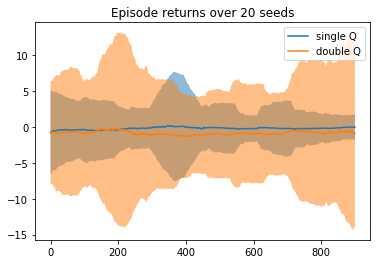

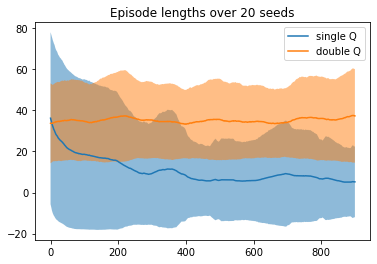

In [82]:
env = roul_env
Q_single = np.copy(Q_single_roul)
Q_double = np.copy(Q_double_roul)

num_seeds = 20
num_episodes = 1000
single_q_lengths, single_q_returns = multiple_runs(env, Q_single, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)
double_q_lengths, double_q_returns = multiple_runs(env, Q_double, num_episodes, num_seeds, alpha=0.1, epsilon=0.1)

plt.title(f'Episode returns over {num_seeds} seeds')
plot_mean_std(single_q_returns, 100, "single Q")
plot_mean_std(double_q_returns, 100, "double Q")
plt.legend()
plt.show()

plt.title(f'Episode lengths over {num_seeds} seeds')
plot_mean_std(single_q_lengths, 100, "single Q")
plot_mean_std(double_q_lengths, 100, "double Q")
plt.legend()
plt.show()
